In [52]:
# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [53]:
# --- 2. Load and Initial Cleaning ---

# Define the file path for easy management.
FILE_PATH = '/Users/selim/Desktop/Projects/Python Projects/Global Freelancer Project/datas/raw/global_freelancers_raw.csv'

# Load the dataset with robust error handling.
try:
    df = pd.read_csv(FILE_PATH)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at the specified path: {FILE_PATH}")
    exit() # Exit the script if the file cannot be loaded.

# Remove any fully duplicate rows to ensure data integrity.
df.drop_duplicates(inplace=True)

Dataset loaded successfully.


In [54]:
# --- 3. Column-by-Column Standardization and Cleaning ---

# -- Gender --
# Standardize to 'F' and 'M' by converting to uppercase, stripping whitespace, and replacing values.
df['gender'] = df['gender'].astype(str).str.upper().str.strip().replace({'FEMALE': 'F', 'MALE': 'M'})

# -- Age --
# Convert to a nullable integer type.
df['age'] = df['age'].astype('Int64')

# -- Years of Experience --
# Rename for easier access and consistency. The type will be converted later.
df.rename(columns={'years_of_experience': 'years_of_exp'}, inplace=True)

# -- Hourly Rate --
# Rename the column and clean the string values by removing currency symbols and text.
df.rename(columns={'hourly_rate (USD)': 'hourly_rate'}, inplace=True)
df['hourly_rate'] = df['hourly_rate'].astype(str).str.replace('USD', '', regex=False).str.replace('$', '', regex=False).str.strip()

# -- Activation Status --
# Use a dictionary map to efficiently standardize various text inputs ('0', 'N', '1', 'Y') to 'No'/'Yes'.
activation_map = {'0': 'No', 'N': 'No', 'no': 'No', '1': 'Yes', 'Y': 'Yes', 'yes': 'Yes'}
df['is_active'] = df['is_active'].map(activation_map)

# -- Client Satisfaction --
# Clean the string values by removing the '%' symbol to prepare for numeric conversion.
df['client_satisfaction'] = df['client_satisfaction'].astype(str).str.strip().replace('%', '', regex=True)

In [55]:
# --- 4. Final Data Type Conversions ---

# Replace various null-like strings with NumPy's standard NaN object across the entire DataFrame.
df.replace(['nan', 'NaN', 'Null', '<NA>'], np.nan, inplace=True)

# Now, convert the cleaned columns to their final, appropriate data types.
# `errors='coerce'` will turn any remaining non-numeric values into NaN, preventing crashes.
df['years_of_exp'] = pd.to_numeric(df['years_of_exp'], errors='coerce').astype('Int64')
df['hourly_rate'] = pd.to_numeric(df['hourly_rate'], errors='coerce')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['client_satisfaction'] = pd.to_numeric(df['client_satisfaction'], errors='coerce')

In [56]:
# --- 5. Verification ---
print("\n--- Data Cleaning and Preparation Complete ---")
print("\n--- DataFrame Head ---")
print(df.head())
print("\n--- DataFrame Info ---")
# .info() is crucial to verify that column names, null counts, and data types are all correct.
df.info()


--- Data Cleaning and Preparation Complete ---

--- DataFrame Head ---
  freelancer_ID             name gender  age    country language  \
0      FL250001  Ms. Nicole Kidd      F   52      Italy  Italian   
1      FL250002   Vanessa Garcia      F   52  Australia  English   
2      FL250003      Juan Nelson      M   53    Germany   German   
3      FL250004   Amanda Spencer      F   38  Australia  English   
4      FL250005  Lynn Curtis DDS      F   53    Germany   German   

            primary_skill  years_of_exp  hourly_rate  rating is_active  \
0  Blockchain Development            11        100.0     NaN        No   
1             Mobile Apps            34        100.0     3.3       Yes   
2          Graphic Design            31         50.0     0.0        No   
3         Web Development             4         40.0     1.5        No   
4         Web Development            27         30.0     4.8        No   

   client_satisfaction  
0                  NaN  
1                 84.0  

In [57]:
# --- 6. Data Modeling: Create Dimension Tables ---

# The following steps create unique, lookup tables for the different categorical attributes
# of the data. This is a standard data warehousing practice (creating a star schema).

# --- 6.1 Dimension: Country ---
# Create a unique, sorted list of countries.
dim_country = df[['country']].drop_duplicates().sort_values('country').reset_index(drop=True)
dim_country.rename(columns={'country': 'country_name'}, inplace=True)
dim_country['country_key'] = dim_country.index + 1 # Create a unique surrogate key.
dim_country = dim_country[['country_key', 'country_name']] # Ensure final column order.

# --- 6.2 Dimension: Language ---
dim_language = df[['language']].drop_duplicates().sort_values('language').reset_index(drop=True)
dim_language.rename(columns={'language': 'language_name'}, inplace=True)
dim_language['language_key'] = dim_language.index + 1
dim_language = dim_language[['language_key', 'language_name']]

# --- 6.3 Dimension: Skill ---
dim_skill = df[['primary_skill']].drop_duplicates().sort_values('primary_skill').reset_index(drop=True)
dim_skill.rename(columns={'primary_skill': 'skill_name'}, inplace=True)
dim_skill['skill_key'] = dim_skill.index + 1
dim_skill = dim_skill[['skill_key', 'skill_name']]

# --- 6.4 Dimension: Freelancer ---
# Create a unique record for each freelancer's demographic information.
freelancer_columns = ['freelancer_ID', 'name', 'gender', 'age', 'is_active']
dim_freelancer = df[freelancer_columns].drop_duplicates().sort_values('freelancer_ID').reset_index(drop=True)
dim_freelancer['freelancer_key'] = dim_freelancer.index + 1
# Reorder columns to place the key first.
dim_freelancer = dim_freelancer[['freelancer_key'] + freelancer_columns]

In [58]:
# --- 7. Data Modeling: Create the Fact Table ---

# The fact table will connect all the dimension keys and hold the quantitative measures (facts).
fact_table = df.copy()

# Join the main data with each dimension table to look up their respective surrogate keys.
fact_table = pd.merge(fact_table, dim_country, left_on='country', right_on='country_name', how='left')
fact_table = pd.merge(fact_table, dim_language, left_on='language', right_on='language_name', how='left')
fact_table = pd.merge(fact_table, dim_skill, left_on='primary_skill', right_on='skill_name', how='left')
fact_table = pd.merge(fact_table, dim_freelancer, on=['freelancer_ID', 'name', 'gender', 'age', 'is_active'], how='left')

# Select only the surrogate keys and the measures to create the final, clean fact table.
fact_columns = [
    'freelancer_key',
    'country_key',
    'language_key',
    'skill_key',
    'years_of_exp',
    'hourly_rate',
    'rating',
    'client_satisfaction'
]
fact_freelancer_stats = fact_table[fact_columns].copy()

In [59]:
# --- 8. Save All DataFrames to CSV ---

# Define the base output path for all final files.
OUTPUT_PATH = '/Users/selim/Desktop/Projects/Python Projects/Global Freelancer Project/datas/final/'

# Use a dictionary to organize the saving process, making it clean and scalable.
files_to_save = {
    'main_freelancer_data.csv': df,
    'dim_country.csv': dim_country,
    'dim_language.csv': dim_language,
    'dim_skill.csv': dim_skill,
    'dim_freelancer.csv': dim_freelancer,
    'fact_freelancer_stats.csv': fact_freelancer_stats
}

print("\n--- Saving all data files ---")
for filename, dataframe in files_to_save.items():
    try:
        full_path = f"{OUTPUT_PATH}{filename}"
        dataframe.to_csv(full_path, index=False)
        print(f"Successfully saved: {filename}")
    except Exception as e:
        print(f"Error saving {filename}: {e}")

print("\n--- Data modeling and saving complete. ---")


--- Saving all data files ---
Successfully saved: main_freelancer_data.csv
Successfully saved: dim_country.csv
Successfully saved: dim_language.csv
Successfully saved: dim_skill.csv
Successfully saved: dim_freelancer.csv
Successfully saved: fact_freelancer_stats.csv

--- Data modeling and saving complete. ---


In [60]:
# --- 9. Final Verification ---
print("\n--- Fact Table Head ---")
print(fact_freelancer_stats.head())
print("\n--- Fact Table Info ---")
fact_freelancer_stats.info()


--- Fact Table Head ---
   freelancer_key  country_key  language_key  skill_key  years_of_exp  \
0               1           11             9          2            11   
1               2            2             4          8            34   
2               3            8             6          6            31   
3               4            2             4         10             4   
4               5            8             6         10            27   

   hourly_rate  rating  client_satisfaction  
0        100.0     NaN                  NaN  
1        100.0     3.3                 84.0  
2         50.0     0.0                 71.0  
3         40.0     1.5                 90.0  
4         30.0     4.8                 83.0  

--- Fact Table Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   freelancer_key       1000

# Analysis 1: Identifying High-Impact Skills
### Business Question: Which specific freelancer skills are most strongly correlated with high client satisfaction scores? Understanding this will allow us to strategically recruit more freelancers with these skills, improve how we feature them on our platform, and ensure our product roadmap supports these high-value service areas, directly impacting client success and reducing their likelihood to churn.
#### Required Columns: client_satisfaction, skill_key, and by extension, the skill_name from the corresponding dimension table.

In [61]:
# --- 1.1 Data Preparation ---

# Join the fact table with the skill dimension to get the skill names.
skill_stats_df = pd.merge(fact_freelancer_stats, dim_skill, on='skill_key', how='left')

# Select only the columns needed for this analysis.
skill_stats_df = skill_stats_df[['skill_name', 'client_satisfaction']]

In [62]:
# --- 1.2 Statistical Analysis of Skill Performance ---

# Group by skill and calculate key statistics to evaluate performance robustly.
# - mean: The average client satisfaction score for the skill.
# - count: The number of freelancers with this skill. Crucial for statistical significance.
# - std: The standard deviation, showing the consistency of satisfaction scores.
skill_summary = skill_stats_df.groupby('skill_name')['client_satisfaction'].agg(
    mean_satisfaction='mean',
    freelancer_count='count',
    satisfaction_std='std'
).sort_values('mean_satisfaction', ascending=False).reset_index()

In [63]:
# --- 1.3 Focus on Statistically Significant Skills ---

# To avoid drawing conclusions from skills with very few data points,
# we filter for skills that have a minimum number of freelancers (e.g., 10 or more).
MIN_FREELANCER_COUNT = 10
significant_skills_summary = skill_summary[skill_summary['freelancer_count'] >= MIN_FREELANCER_COUNT].copy()

# Print the detailed summary table for review. This is the core data driving the analysis.
print(f"--- Skill Performance Summary (for skills with >= {MIN_FREELANCER_COUNT} freelancers) ---")
print(significant_skills_summary)

--- Skill Performance Summary (for skills with >= 10 freelancers) ---
               skill_name  mean_satisfaction  freelancer_count  \
0  Blockchain Development          80.482353                85   
1            UI/UX Design          80.219780                91   
2                      AI          80.133333                75   
3          Graphic Design          79.475610                82   
4         Web Development          79.181818                88   
5                  DevOps          78.879121                91   
6             Mobile Apps          78.625000                80   
7           Cybersecurity          78.520548                73   
8           Data Analysis          78.518987                79   
9        Machine Learning          78.487500                80   

   satisfaction_std  
0         11.726660  
1         11.233682  
2         12.404591  
3         11.832395  
4         11.486669  
5         11.648400  
6         11.332015  
7         10.626369  
8    

/var/folders/3k/dwn327qx17928cqr783mk7qc0000gn/T/ipykernel_69610/2676406474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


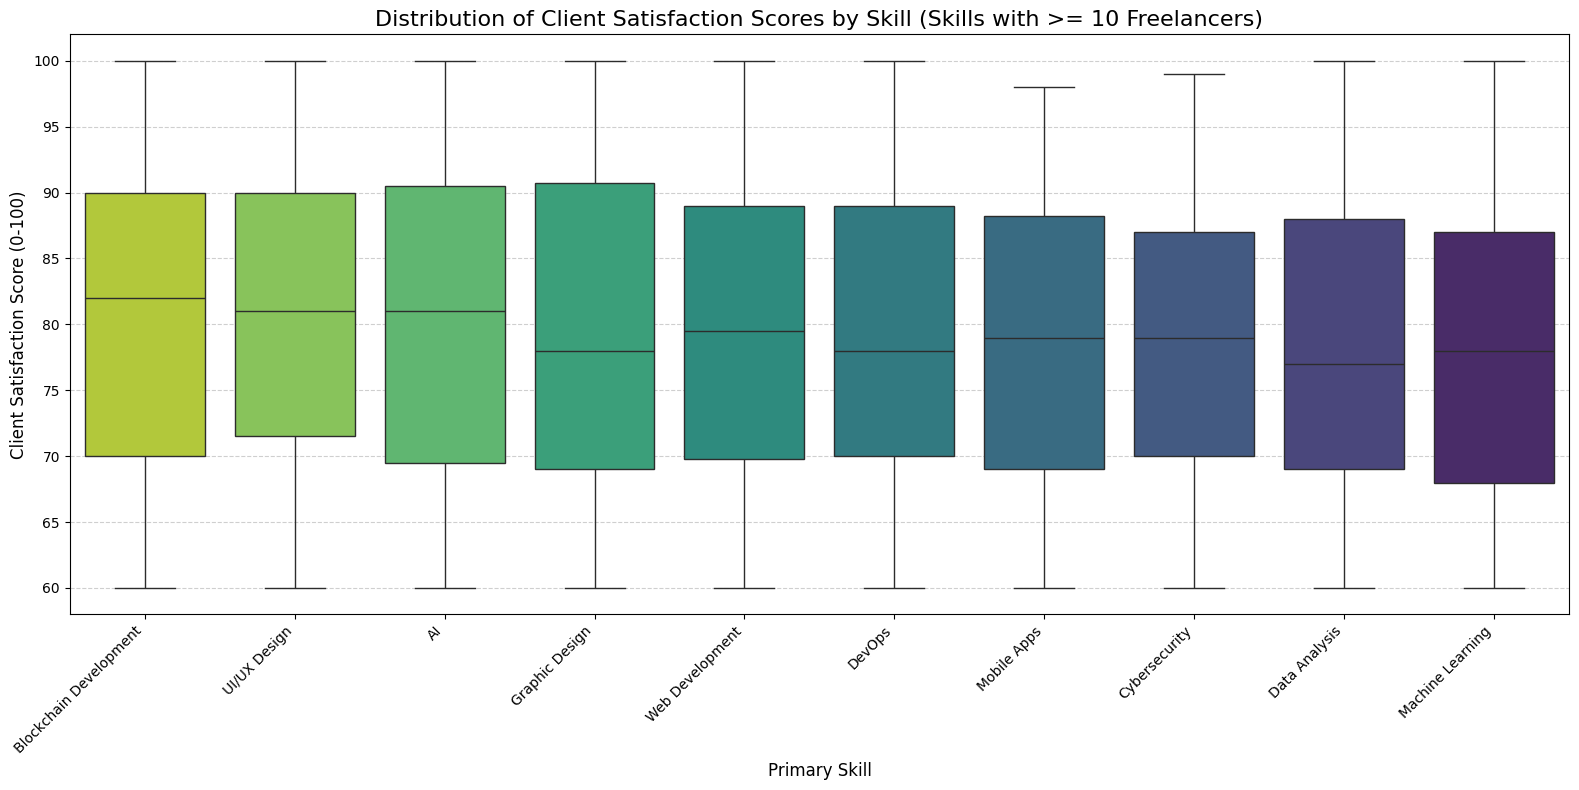

In [64]:
# --- 1.4 Visualization: Distribution of Satisfaction by Skill ---

# Filter the original DataFrame to only include the significant skills for plotting.
plot_df = skill_stats_df[skill_stats_df['skill_name'].isin(significant_skills_summary['skill_name'])]

plt.figure(figsize=(16, 8))

# A boxplot is an excellent way to see the full distribution (median, quartiles, range) of scores for each skill.
sns.boxplot(
    data=plot_df,
    x='skill_name',
    y='client_satisfaction',
    palette='viridis_r', # Reversed palette to make high scores darker
    # This 'order' parameter is key: it arranges the boxplots based on the mean satisfaction we calculated.
    order=significant_skills_summary['skill_name']
)

# --- Formatting and Labels ---
plt.title(f'Distribution of Client Satisfaction Scores by Skill (Skills with >= {MIN_FREELANCER_COUNT} Freelancers)', fontsize=16)
plt.xlabel('Primary Skill', fontsize=12)
plt.ylabel('Client Satisfaction Score (0-100)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust plot to ensure everything fits
plt.show()

# Analysis 2: The "Value for Money" sweet spot
### Business Question: What is the relationship between a freelancer's hourly_rate, years_of_exp, and the resulting client_satisfaction? I want to determine if there is an optimal range of experience and cost that consistently leads to higher client satisfaction. This insight would enable us to build a recommendation engine or provide better guidance to our users, helping them hire freelancers who provide the best value and reducing churn caused by poor hiring decisions.
#### Required Columns: hourly_rate, years_of_exp, client_satisfaction.

In [65]:
# --- 2.1 Data Preparation ---

# Select the necessary columns and drop rows where the hourly rate is missing,
# as it's essential for this analysis.
value_df = fact_freelancer_stats[['years_of_exp', 'hourly_rate', 'client_satisfaction']].dropna(subset=['hourly_rate']).copy()

In [66]:
# --- 2.2 Feature Engineering: Create Tiers for Experience and Rate ---

# Define bins and labels to categorize freelancers by their years of experience.
bins_seniority = [0, 2, 5, 10, 20, value_df['years_of_exp'].max()]
labels_seniority = ['Junior (0-2 yrs)', 'Mid (3-5 yrs)', 'Experienced (6-10 yrs)', 'Senior (11-20 yrs)', 'Expert (20+ yrs)']
value_df['seniority_level'] = pd.cut(value_df['years_of_exp'], bins=bins_seniority, labels=labels_seniority, include_lowest=True)

# Define bins and labels to categorize freelancers by their hourly rate.
bins_hourly_rate = [0, 30, 50, 75, value_df['hourly_rate'].max()]
labels_hourly_rate = ["Budget (<$30)", "Affordable ($30-50)", "Expensive ($50-75)", "Premium (>$75)"]
value_df['hourly_rate_tier'] = pd.cut(value_df['hourly_rate'], bins=bins_hourly_rate, labels=labels_hourly_rate, include_lowest=True)

In [67]:
value_df

,years_of_exp,hourly_rate,client_satisfaction,seniority_level,hourly_rate_tier
0,11,100.0,NaN,Senior (11-20 yrs),Premium (>$75)
1,34,100.0,84.0,Expert (20+ yrs),Premium (>$75)
2,31,50.0,71.0,Expert (20+ yrs),Affordable ($30-50)
3,4,40.0,90.0,Mid (3-5 yrs),Affordable ($30-50)
4,27,30.0,83.0,Expert (20+ yrs),Budget (<$30)
...,...,...,...,...,...
995,13,100.0,68.0,Senior (11-20 yrs),Premium (>$75)
996,6,40.0,82.0,Experienced (6-10 yrs),Affordable ($30-50)
997,15,75.0,94.0,Senior (11-20 yrs),Expensive ($50-75)
998,22,100.0,97.0,Expert (20+ yrs),Premium (>$75)


In [68]:
# --- 2.3 Aggregate Data for Heatmap ---

# Group by the newly created seniority and rate tiers, then calculate the mean client satisfaction.
# .unstack() pivots the data, creating the matrix format required for a heatmap.
satisfaction_heatmap_data = value_df.groupby(['seniority_level', 'hourly_rate_tier'])['client_satisfaction'].agg('mean').unstack().round(2)

/var/folders/3k/dwn327qx17928cqr783mk7qc0000gn/T/ipykernel_69610/910911502.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  satisfaction_heatmap_data = value_df.groupby(['seniority_level', 'hourly_rate_tier'])['client_satisfaction'].agg('mean').unstack().round(2)


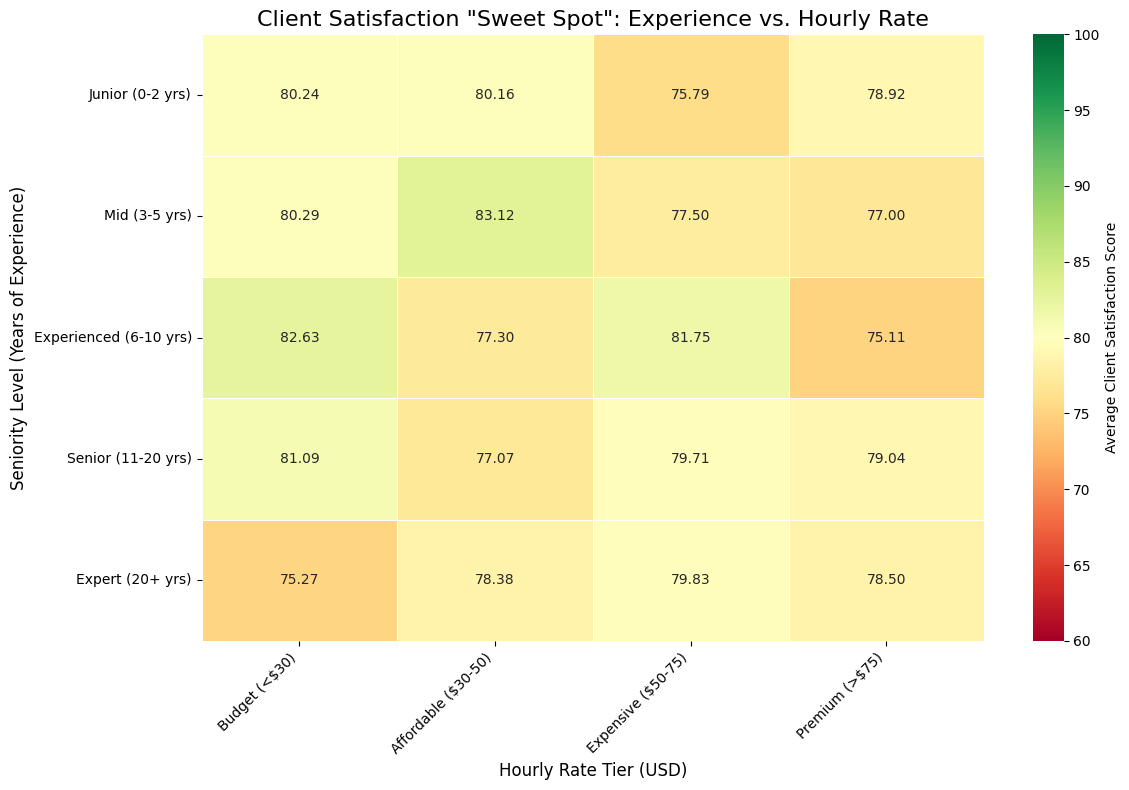

--- Average Client Satisfaction by Seniority and Hourly Rate ---
hourly_rate_tier        Budget (<$30)  Affordable ($30-50)  \
seniority_level                                              
Junior (0-2 yrs)                80.24                80.16   
Mid (3-5 yrs)                   80.29                83.12   
Experienced (6-10 yrs)          82.63                77.30   
Senior (11-20 yrs)              81.09                77.07   
Expert (20+ yrs)                75.27                78.38   

hourly_rate_tier        Expensive ($50-75)  Premium (>$75)  
seniority_level                                             
Junior (0-2 yrs)                     75.79           78.92  
Mid (3-5 yrs)                        77.50           77.00  
Experienced (6-10 yrs)               81.75           75.11  
Senior (11-20 yrs)                   79.71           79.04  
Expert (20+ yrs)                     79.83           78.50  


In [69]:
# --- 2.4 Visualization: Client Satisfaction Heatmap ---

plt.figure(figsize=(12, 8))

# A heatmap is the perfect visualization to show the interaction between two categorical variables on a third, continuous variable.
sns.heatmap(
    data=satisfaction_heatmap_data,
    cmap='RdYlGn',     # A diverging colormap is ideal for satisfaction scores.
    annot=True,       # Display the numerical value in each cell.
    fmt='.2f',        # Format the numbers to two decimal places.
    linewidths=.5,    # Add lines between cells for better separation.
    vmin=60,          # Set the minimum for the color scale to anchor the visual comparison.
    vmax=100,         # Set the maximum for the color scale.
    cbar_kws={'label': 'Average Client Satisfaction Score'} # Label for the color bar.
)

# --- Formatting and Labels ---
plt.title('Client Satisfaction "Sweet Spot": Experience vs. Hourly Rate', fontsize=16)
plt.xlabel('Hourly Rate Tier (USD)', fontsize=12)
plt.ylabel('Seniority Level (Years of Experience)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Display the summary data for review ---
print("--- Average Client Satisfaction by Seniority and Hourly Rate ---")
print(satisfaction_heatmap_data)

# Analysis 3: Verifying Our Internal Quality Metrics
### Business Question: How well does our internal rating system predict actual client_satisfaction? It is critical to know if our own quality indicators are reliable. If freelancers with high ratings are not delivering work that results in high client satisfaction, our platform is failing to guide users effectively, which could be a significant cause of churn.
#### Required Columns: rating, client_satisfaction.

In [70]:
# --- 3.1 Data Preparation ---

# Select only the columns needed for this correlation analysis.
internal_quality_df = fact_freelancer_stats[['rating', 'client_satisfaction']].dropna()

In [71]:
# --- 3.2 Statistical Analysis: Calculate Correlation ---

# Calculate the Pearson correlation coefficient between the internal rating and client satisfaction.
# This single number quantifies the strength and direction of the linear relationship.
correlation_coefficient = internal_quality_df['rating'].corr(internal_quality_df['client_satisfaction'])

# Display the correlation coefficient.
print(f"--- Correlation Analysis ---")
print(f"The Pearson correlation coefficient between 'rating' and 'client_satisfaction' is: {correlation_coefficient:.4f}")

--- Correlation Analysis ---
The Pearson correlation coefficient between 'rating' and 'client_satisfaction' is: -0.0013


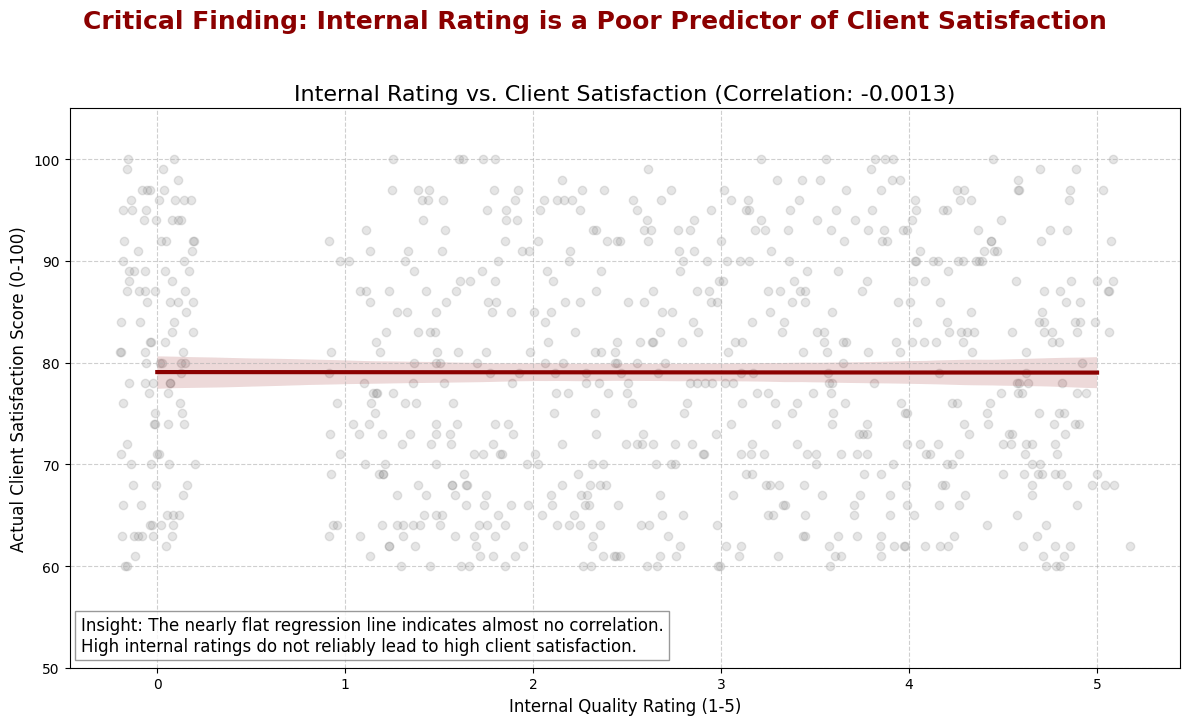

In [72]:
# --- 3.3 Visualization: Rating vs. Client Satisfaction ---

plt.figure(figsize=(12, 7))

# A regression plot (regplot) is the ideal choice for visualizing the relationship
# between two continuous variables and assessing the correlation.
sns.regplot(
    data=internal_quality_df,
    x='rating',
    y='client_satisfaction',
    x_jitter=0.2,                                # Adds noise to the x-axis to prevent points from overlapping vertically.
    scatter_kws={'alpha': 0.2, 'color': 'gray'}, # Makes the individual points less prominent.
    line_kws={'color': 'darkred', 'linewidth': 3}     # Emphasizes the regression line.
)

# --- Formatting and Annotations ---
# The title is crafted to be a key takeaway, immediately highlighting the business insight.
plt.title(f'Internal Rating vs. Client Satisfaction (Correlation: {correlation_coefficient:.4f})', fontsize=16)
plt.suptitle('Critical Finding: Internal Rating is a Poor Predictor of Client Satisfaction',
             fontsize=18, color='darkred', weight='bold', y=1.03)

plt.xlabel('Internal Quality Rating (1-5)', fontsize=12)
plt.ylabel('Actual Client Satisfaction Score (0-100)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(50, 105) # Set y-axis limits to focus on the main data range.

# Add a text box to explicitly interpret the "flat line" for the audience.
plt.text(
    x=0.01, y=0.03, # Position in the bottom-left corner of the axes
    s="Insight: The nearly flat regression line indicates almost no correlation.\nHigh internal ratings do not reliably lead to high client satisfaction.",
    transform=plt.gca().transAxes, # Use axes coordinates for positioning
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.tight_layout()
plt.show()

# Analysis 4: Geographic and Language-Based Performance
### Business Question: Are there specific countries or languages where freelancers consistently achieve higher client satisfaction? This analysis could uncover hidden gems in our talent pool or highlight potential communication barriers. By understanding these patterns, we can refine our international acquisition strategy and provide better cross-cultural communication tools within our product, leading to better project outcomes and higher client retention.
#### Required Columns: client_satisfaction, country_key, language_key, and the corresponding country_name and language_name from their respective dimension tables.


In [73]:
# --- 4.1 Data Preparation ---

# Join the fact table with country and language dimensions to get the necessary labels.
geo_lang_df = pd.merge(fact_freelancer_stats, dim_country, on='country_key', how='left')
geo_lang_df = pd.merge(geo_lang_df, dim_language, on='language_key', how='left')
geo_lang_df = geo_lang_df[['client_satisfaction', 'country_name', 'language_name']]

# Calculate the global average satisfaction to use as a benchmark in our plots.
global_avg_satisfaction = geo_lang_df['client_satisfaction'].mean()

# Define a minimum threshold for projects to ensure statistical significance in our analysis.
MIN_PROJECT_COUNT = 50

/var/folders/3k/dwn327qx17928cqr783mk7qc0000gn/T/ipykernel_69610/1286972871.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


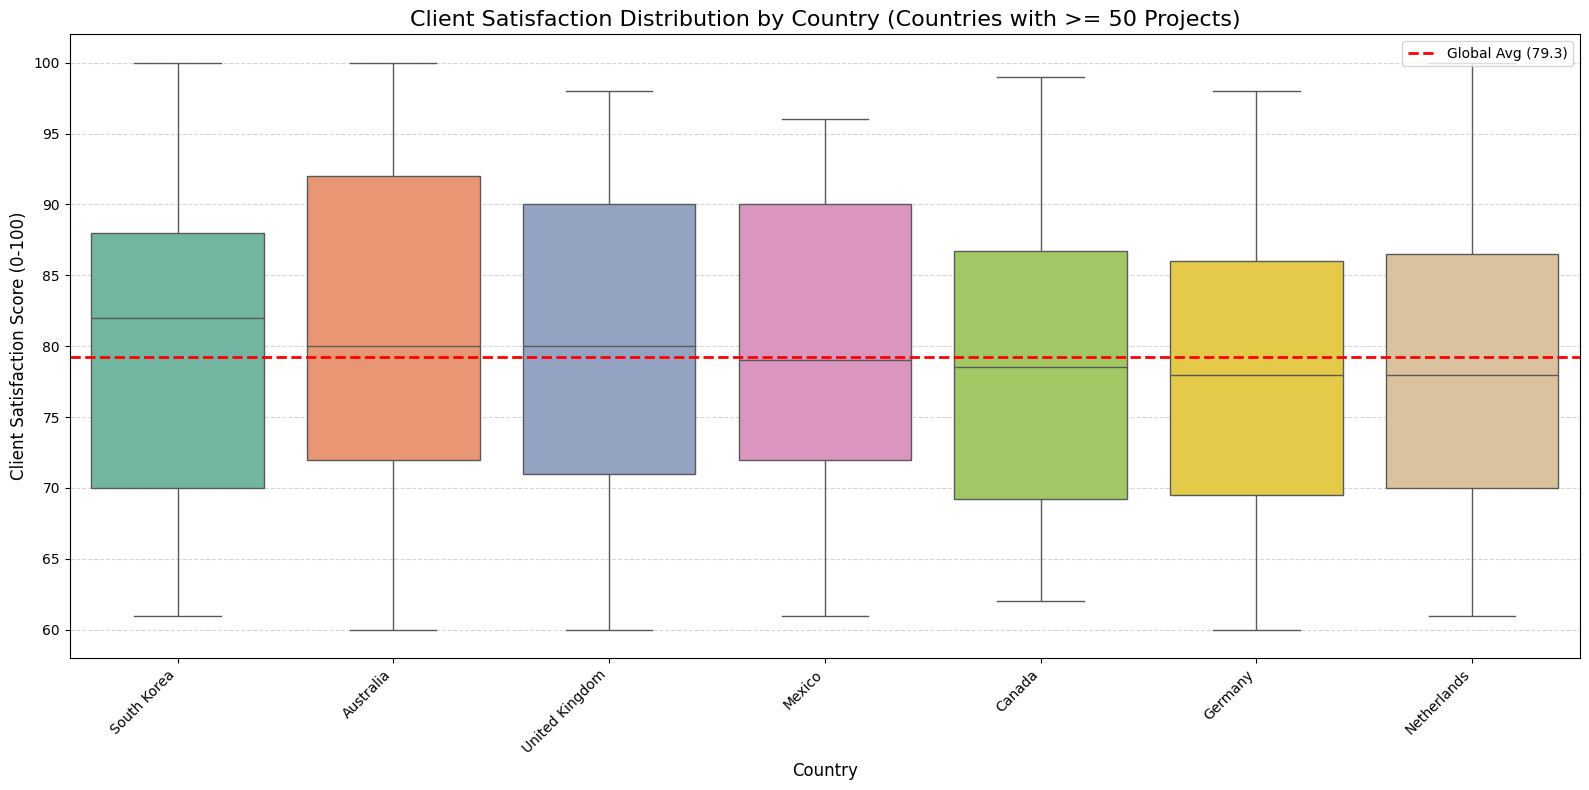

In [74]:
# --- 4.2 Geographic Performance Analysis by Country ---

# --- Filtering and Sorting ---
# Identify countries that meet our minimum project count threshold.
country_counts = geo_lang_df['country_name'].value_counts()
significant_countries = country_counts[country_counts >= MIN_PROJECT_COUNT].index

# Filter the DataFrame to include only these significant countries.
country_analysis_df = geo_lang_df[geo_lang_df['country_name'].isin(significant_countries)].copy()

# Determine the plot order by sorting countries based on their median client satisfaction.
sorted_country_order = country_analysis_df.groupby('country_name')['client_satisfaction'].median().sort_values(ascending=False).index

# --- Visualization by Country ---
plt.figure(figsize=(16, 8))

sns.boxplot(
    data=country_analysis_df,
    x='country_name',
    y='client_satisfaction',
    order=sorted_country_order, # Apply the calculated order
    palette='Set2',
    showfliers=False # Hide outliers to focus on the main distribution
)

# Add the global average line as a benchmark.
plt.axhline(global_avg_satisfaction, color='red', linestyle='--', linewidth=2, label=f'Global Avg ({global_avg_satisfaction:.1f})')

# --- Formatting and Labels ---
plt.title(f'Client Satisfaction Distribution by Country (Countries with >= {MIN_PROJECT_COUNT} Projects)', fontsize=16)
plt.ylabel('Client Satisfaction Score (0-100)', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

/var/folders/3k/dwn327qx17928cqr783mk7qc0000gn/T/ipykernel_69610/3038560638.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


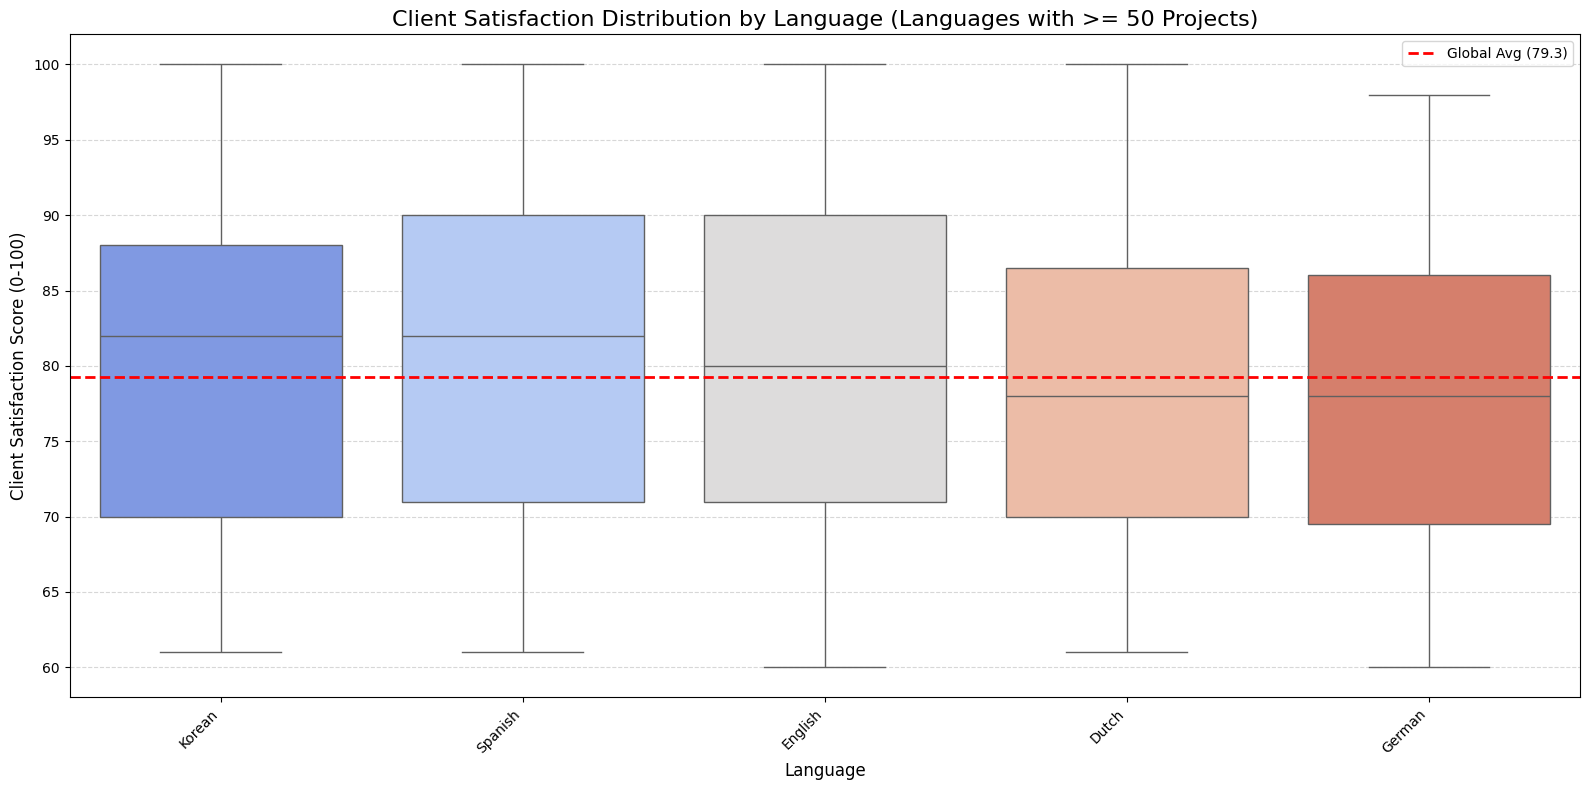

In [75]:
# --- 4.3 Performance Analysis by Language ---

# --- Filtering and Sorting ---
# Identify languages that meet our minimum project count threshold.
language_counts = geo_lang_df['language_name'].value_counts()
significant_languages = language_counts[language_counts >= MIN_PROJECT_COUNT].index

# Filter the DataFrame to include only these significant languages.
language_analysis_df = geo_lang_df[geo_lang_df['language_name'].isin(significant_languages)].copy()

# Determine the plot order by sorting languages based on their median client satisfaction.
sorted_language_order = language_analysis_df.groupby('language_name')['client_satisfaction'].median().sort_values(ascending=False).index

# --- Visualization by Language ---
plt.figure(figsize=(16, 8))

sns.boxplot(
    data=language_analysis_df,
    x='language_name',
    y='client_satisfaction',
    order=sorted_language_order, # Apply the calculated order
    palette='coolwarm',
    showfliers=False
)

# Add the global average line as a benchmark.
plt.axhline(global_avg_satisfaction, color='red', linestyle='--', linewidth=2, label=f'Global Avg ({global_avg_satisfaction:.1f})')

# --- Formatting and Labels ---
plt.title(f'Client Satisfaction Distribution by Language (Languages with >= {MIN_PROJECT_COUNT} Projects)', fontsize=16)
plt.ylabel('Client Satisfaction Score (0-100)', fontsize=12)
plt.xlabel('Language', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()